# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

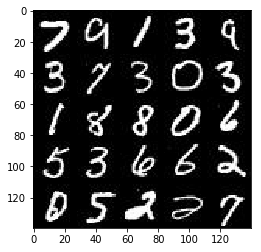

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

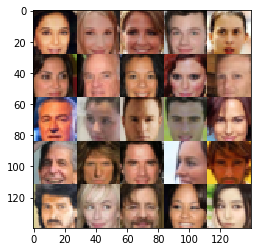

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    tf.maximum(x, alpha * x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = leaky_relu(x1, alpha=0.01)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = leaky_relu(bn2, alpha=0.01)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = leaky_relu(bn3, alpha=0.01)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01
        h1 = tf.layers.dense(z, out_channel_dim, activation=None)
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = leaky_relu(x1, alpha=0.01)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 = leaky_relu(x2, alpha = 0.01)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = leaky_relu(x3, alpha = 0.01)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator network here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_logits_real)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """ 
    #model_inputs(image_width, image_height, image_channels, z_dim):
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, i, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [25]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)


(60000, 28, 28, 1)


Epoch 1/2 - Batch 10/1875:  Discriminator Loss: 0.5180... Generator Loss: 1.9678
Epoch 1/2 - Batch 20/1875:  Discriminator Loss: 0.4751... Generator Loss: 2.7750
Epoch 1/2 - Batch 30/1875:  Discriminator Loss: 1.7072... Generator Loss: 0.3862
Epoch 1/2 - Batch 40/1875:  Discriminator Loss: 0.4504... Generator Loss: 4.6588
Epoch 1/2 - Batch 50/1875:  Discriminator Loss: 0.5034... Generator Loss: 2.2830
Epoch 1/2 - Batch 60/1875:  Discriminator Loss: 0.4045... Generator Loss: 3.1592
Epoch 1/2 - Batch 70/1875:  Discriminator Loss: 0.3918... Generator Loss: 3.1459
Epoch 1/2 - Batch 80/1875:  Discriminator Loss: 0.4306... Generator Loss: 2.6007
Epoch 1/2 - Batch 90/1875:  Discriminator Loss: 0.3913... Generator Loss: 3.1411


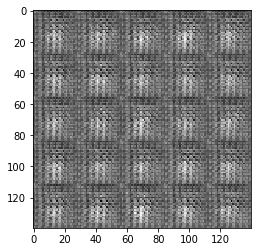

Epoch 1/2 - Batch 100/1875:  Discriminator Loss: 0.3723... Generator Loss: 4.6259
Epoch 1/2 - Batch 110/1875:  Discriminator Loss: 0.7552... Generator Loss: 1.2567
Epoch 1/2 - Batch 120/1875:  Discriminator Loss: 0.3793... Generator Loss: 3.6353
Epoch 1/2 - Batch 130/1875:  Discriminator Loss: 0.3611... Generator Loss: 4.5973
Epoch 1/2 - Batch 140/1875:  Discriminator Loss: 0.3623... Generator Loss: 4.3923
Epoch 1/2 - Batch 150/1875:  Discriminator Loss: 0.3709... Generator Loss: 4.1313
Epoch 1/2 - Batch 160/1875:  Discriminator Loss: 0.4151... Generator Loss: 3.0874
Epoch 1/2 - Batch 170/1875:  Discriminator Loss: 0.3851... Generator Loss: 3.5045
Epoch 1/2 - Batch 180/1875:  Discriminator Loss: 0.3623... Generator Loss: 4.0962
Epoch 1/2 - Batch 190/1875:  Discriminator Loss: 0.4321... Generator Loss: 3.7763


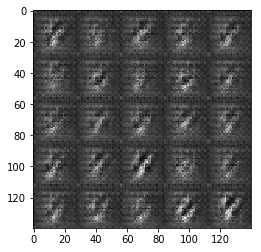

Epoch 1/2 - Batch 200/1875:  Discriminator Loss: 2.4826... Generator Loss: 0.3707
Epoch 1/2 - Batch 210/1875:  Discriminator Loss: 0.7789... Generator Loss: 1.3700
Epoch 1/2 - Batch 220/1875:  Discriminator Loss: 0.6115... Generator Loss: 2.1166
Epoch 1/2 - Batch 230/1875:  Discriminator Loss: 0.4697... Generator Loss: 2.7246
Epoch 1/2 - Batch 240/1875:  Discriminator Loss: 0.4281... Generator Loss: 3.2293
Epoch 1/2 - Batch 250/1875:  Discriminator Loss: 0.4863... Generator Loss: 3.0055
Epoch 1/2 - Batch 260/1875:  Discriminator Loss: 0.9044... Generator Loss: 1.1137
Epoch 1/2 - Batch 270/1875:  Discriminator Loss: 0.4700... Generator Loss: 3.0529
Epoch 1/2 - Batch 280/1875:  Discriminator Loss: 0.5294... Generator Loss: 3.0154
Epoch 1/2 - Batch 290/1875:  Discriminator Loss: 0.5748... Generator Loss: 1.8983


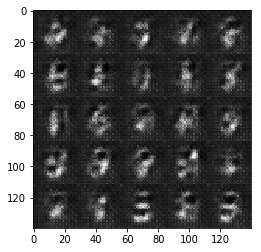

Epoch 1/2 - Batch 300/1875:  Discriminator Loss: 0.5451... Generator Loss: 2.1910
Epoch 1/2 - Batch 310/1875:  Discriminator Loss: 1.0133... Generator Loss: 0.9700
Epoch 1/2 - Batch 320/1875:  Discriminator Loss: 0.5204... Generator Loss: 2.7915
Epoch 1/2 - Batch 330/1875:  Discriminator Loss: 0.5686... Generator Loss: 2.3635
Epoch 1/2 - Batch 340/1875:  Discriminator Loss: 0.6933... Generator Loss: 1.4355
Epoch 1/2 - Batch 350/1875:  Discriminator Loss: 0.4795... Generator Loss: 2.5270
Epoch 1/2 - Batch 360/1875:  Discriminator Loss: 0.5434... Generator Loss: 2.1494
Epoch 1/2 - Batch 370/1875:  Discriminator Loss: 0.5174... Generator Loss: 2.3956
Epoch 1/2 - Batch 380/1875:  Discriminator Loss: 0.5096... Generator Loss: 2.2721
Epoch 1/2 - Batch 390/1875:  Discriminator Loss: 0.4873... Generator Loss: 2.4761


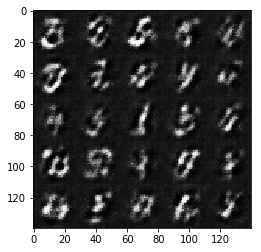

Epoch 1/2 - Batch 400/1875:  Discriminator Loss: 0.5562... Generator Loss: 2.0629
Epoch 1/2 - Batch 410/1875:  Discriminator Loss: 0.5113... Generator Loss: 2.0903
Epoch 1/2 - Batch 420/1875:  Discriminator Loss: 0.7235... Generator Loss: 1.5166
Epoch 1/2 - Batch 430/1875:  Discriminator Loss: 0.5719... Generator Loss: 2.0498
Epoch 1/2 - Batch 440/1875:  Discriminator Loss: 0.5466... Generator Loss: 2.3543
Epoch 1/2 - Batch 450/1875:  Discriminator Loss: 0.6228... Generator Loss: 2.2635
Epoch 1/2 - Batch 460/1875:  Discriminator Loss: 0.5195... Generator Loss: 3.2649
Epoch 1/2 - Batch 470/1875:  Discriminator Loss: 0.7744... Generator Loss: 1.4362
Epoch 1/2 - Batch 480/1875:  Discriminator Loss: 0.4823... Generator Loss: 2.6062
Epoch 1/2 - Batch 490/1875:  Discriminator Loss: 0.4625... Generator Loss: 2.7265


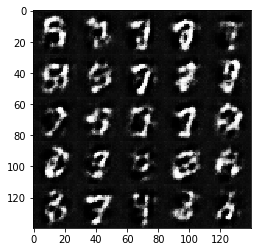

Epoch 1/2 - Batch 500/1875:  Discriminator Loss: 0.4868... Generator Loss: 2.3976
Epoch 1/2 - Batch 510/1875:  Discriminator Loss: 0.6646... Generator Loss: 4.3840
Epoch 1/2 - Batch 520/1875:  Discriminator Loss: 0.5887... Generator Loss: 1.8560
Epoch 1/2 - Batch 530/1875:  Discriminator Loss: 0.6665... Generator Loss: 1.5729
Epoch 1/2 - Batch 540/1875:  Discriminator Loss: 0.6898... Generator Loss: 4.4277
Epoch 1/2 - Batch 550/1875:  Discriminator Loss: 0.5366... Generator Loss: 2.1036
Epoch 1/2 - Batch 560/1875:  Discriminator Loss: 0.5446... Generator Loss: 3.3156
Epoch 1/2 - Batch 570/1875:  Discriminator Loss: 0.7264... Generator Loss: 3.8610
Epoch 1/2 - Batch 580/1875:  Discriminator Loss: 0.5568... Generator Loss: 1.8095
Epoch 1/2 - Batch 590/1875:  Discriminator Loss: 0.5742... Generator Loss: 2.4112


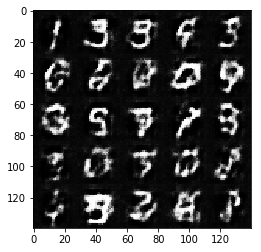

Epoch 1/2 - Batch 600/1875:  Discriminator Loss: 0.6024... Generator Loss: 2.8256
Epoch 1/2 - Batch 610/1875:  Discriminator Loss: 0.6362... Generator Loss: 3.0649
Epoch 1/2 - Batch 620/1875:  Discriminator Loss: 0.5678... Generator Loss: 1.9700
Epoch 1/2 - Batch 630/1875:  Discriminator Loss: 0.9043... Generator Loss: 1.1862
Epoch 1/2 - Batch 640/1875:  Discriminator Loss: 0.5468... Generator Loss: 2.0219
Epoch 1/2 - Batch 650/1875:  Discriminator Loss: 0.6606... Generator Loss: 1.5204
Epoch 1/2 - Batch 660/1875:  Discriminator Loss: 0.5994... Generator Loss: 1.6936
Epoch 1/2 - Batch 670/1875:  Discriminator Loss: 0.6226... Generator Loss: 2.5292
Epoch 1/2 - Batch 680/1875:  Discriminator Loss: 0.7484... Generator Loss: 1.2950
Epoch 1/2 - Batch 690/1875:  Discriminator Loss: 0.5711... Generator Loss: 2.4708


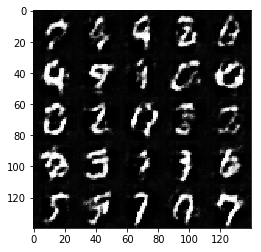

Epoch 1/2 - Batch 700/1875:  Discriminator Loss: 0.5914... Generator Loss: 2.4091
Epoch 1/2 - Batch 710/1875:  Discriminator Loss: 0.6822... Generator Loss: 1.4447
Epoch 1/2 - Batch 720/1875:  Discriminator Loss: 0.6832... Generator Loss: 1.6176
Epoch 1/2 - Batch 730/1875:  Discriminator Loss: 0.6784... Generator Loss: 1.7063
Epoch 1/2 - Batch 740/1875:  Discriminator Loss: 0.6065... Generator Loss: 1.9659
Epoch 1/2 - Batch 750/1875:  Discriminator Loss: 0.5420... Generator Loss: 2.3557
Epoch 1/2 - Batch 760/1875:  Discriminator Loss: 0.8920... Generator Loss: 1.0692
Epoch 1/2 - Batch 770/1875:  Discriminator Loss: 0.5782... Generator Loss: 2.5064
Epoch 1/2 - Batch 780/1875:  Discriminator Loss: 1.3200... Generator Loss: 0.6220
Epoch 1/2 - Batch 790/1875:  Discriminator Loss: 0.7645... Generator Loss: 1.3882


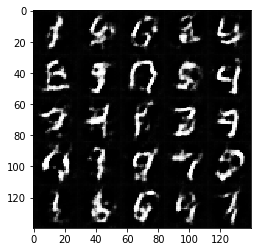

Epoch 1/2 - Batch 800/1875:  Discriminator Loss: 0.9526... Generator Loss: 3.6882
Epoch 1/2 - Batch 810/1875:  Discriminator Loss: 0.6729... Generator Loss: 1.5191
Epoch 1/2 - Batch 820/1875:  Discriminator Loss: 0.4955... Generator Loss: 2.4387
Epoch 1/2 - Batch 830/1875:  Discriminator Loss: 0.8653... Generator Loss: 1.1484
Epoch 1/2 - Batch 840/1875:  Discriminator Loss: 0.6086... Generator Loss: 2.0908
Epoch 1/2 - Batch 850/1875:  Discriminator Loss: 0.5945... Generator Loss: 2.2681
Epoch 1/2 - Batch 860/1875:  Discriminator Loss: 0.7481... Generator Loss: 2.9822
Epoch 1/2 - Batch 870/1875:  Discriminator Loss: 0.7283... Generator Loss: 2.8890
Epoch 1/2 - Batch 880/1875:  Discriminator Loss: 0.9754... Generator Loss: 3.8213
Epoch 1/2 - Batch 890/1875:  Discriminator Loss: 0.5640... Generator Loss: 2.0938


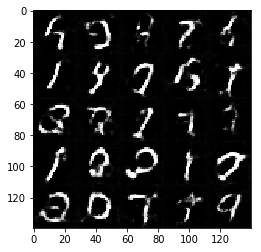

Epoch 1/2 - Batch 900/1875:  Discriminator Loss: 0.7370... Generator Loss: 1.3873
Epoch 1/2 - Batch 910/1875:  Discriminator Loss: 0.7620... Generator Loss: 2.9298
Epoch 1/2 - Batch 920/1875:  Discriminator Loss: 0.7314... Generator Loss: 1.3316
Epoch 1/2 - Batch 930/1875:  Discriminator Loss: 0.6101... Generator Loss: 1.8275
Epoch 1/2 - Batch 940/1875:  Discriminator Loss: 1.2542... Generator Loss: 3.9917
Epoch 1/2 - Batch 950/1875:  Discriminator Loss: 0.7235... Generator Loss: 1.4102
Epoch 1/2 - Batch 960/1875:  Discriminator Loss: 0.5966... Generator Loss: 2.0107
Epoch 1/2 - Batch 970/1875:  Discriminator Loss: 0.8430... Generator Loss: 1.1469
Epoch 1/2 - Batch 980/1875:  Discriminator Loss: 0.7302... Generator Loss: 1.4625
Epoch 1/2 - Batch 990/1875:  Discriminator Loss: 0.9025... Generator Loss: 1.0353


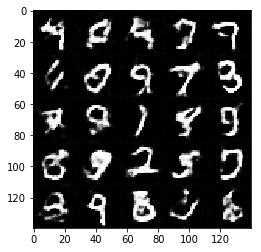

Epoch 1/2 - Batch 1000/1875:  Discriminator Loss: 0.8103... Generator Loss: 1.1809
Epoch 1/2 - Batch 1010/1875:  Discriminator Loss: 0.5083... Generator Loss: 2.5175
Epoch 1/2 - Batch 1020/1875:  Discriminator Loss: 0.9647... Generator Loss: 0.9368
Epoch 1/2 - Batch 1030/1875:  Discriminator Loss: 0.5702... Generator Loss: 2.4454
Epoch 1/2 - Batch 1040/1875:  Discriminator Loss: 0.7400... Generator Loss: 1.3782
Epoch 1/2 - Batch 1050/1875:  Discriminator Loss: 0.9964... Generator Loss: 0.9509
Epoch 1/2 - Batch 1060/1875:  Discriminator Loss: 0.6512... Generator Loss: 2.4032
Epoch 1/2 - Batch 1070/1875:  Discriminator Loss: 0.8488... Generator Loss: 1.1550
Epoch 1/2 - Batch 1080/1875:  Discriminator Loss: 0.6110... Generator Loss: 1.7438
Epoch 1/2 - Batch 1090/1875:  Discriminator Loss: 0.6446... Generator Loss: 1.6126


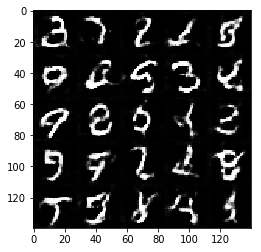

Epoch 1/2 - Batch 1100/1875:  Discriminator Loss: 0.7209... Generator Loss: 1.4752
Epoch 1/2 - Batch 1110/1875:  Discriminator Loss: 0.6841... Generator Loss: 2.4192
Epoch 1/2 - Batch 1120/1875:  Discriminator Loss: 0.6497... Generator Loss: 1.8743
Epoch 1/2 - Batch 1130/1875:  Discriminator Loss: 0.7937... Generator Loss: 1.1853
Epoch 1/2 - Batch 1140/1875:  Discriminator Loss: 1.3650... Generator Loss: 3.7359
Epoch 1/2 - Batch 1150/1875:  Discriminator Loss: 0.6315... Generator Loss: 2.2004
Epoch 1/2 - Batch 1160/1875:  Discriminator Loss: 0.8855... Generator Loss: 1.0556
Epoch 1/2 - Batch 1170/1875:  Discriminator Loss: 0.6288... Generator Loss: 1.9898
Epoch 1/2 - Batch 1180/1875:  Discriminator Loss: 0.6090... Generator Loss: 1.9503
Epoch 1/2 - Batch 1190/1875:  Discriminator Loss: 0.5267... Generator Loss: 2.0982


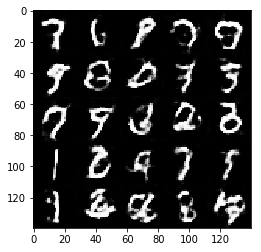

Epoch 1/2 - Batch 1200/1875:  Discriminator Loss: 0.8854... Generator Loss: 1.1235
Epoch 1/2 - Batch 1210/1875:  Discriminator Loss: 0.6107... Generator Loss: 1.7194
Epoch 1/2 - Batch 1220/1875:  Discriminator Loss: 0.7885... Generator Loss: 1.2833
Epoch 1/2 - Batch 1230/1875:  Discriminator Loss: 0.6523... Generator Loss: 1.7256
Epoch 1/2 - Batch 1240/1875:  Discriminator Loss: 0.6172... Generator Loss: 1.6422
Epoch 1/2 - Batch 1250/1875:  Discriminator Loss: 0.7980... Generator Loss: 1.2248
Epoch 1/2 - Batch 1260/1875:  Discriminator Loss: 0.7296... Generator Loss: 1.2650
Epoch 1/2 - Batch 1270/1875:  Discriminator Loss: 0.8071... Generator Loss: 1.2457
Epoch 1/2 - Batch 1280/1875:  Discriminator Loss: 0.5369... Generator Loss: 2.2019
Epoch 1/2 - Batch 1290/1875:  Discriminator Loss: 0.8952... Generator Loss: 1.0799


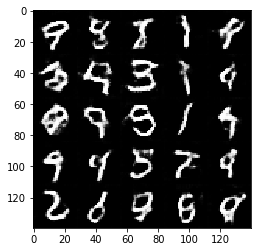

Epoch 1/2 - Batch 1300/1875:  Discriminator Loss: 0.5942... Generator Loss: 1.7995
Epoch 1/2 - Batch 1310/1875:  Discriminator Loss: 6.1961... Generator Loss: 0.0087
Epoch 1/2 - Batch 1320/1875:  Discriminator Loss: 0.7676... Generator Loss: 1.5395
Epoch 1/2 - Batch 1330/1875:  Discriminator Loss: 0.7312... Generator Loss: 1.3724
Epoch 1/2 - Batch 1340/1875:  Discriminator Loss: 0.8206... Generator Loss: 1.1599
Epoch 1/2 - Batch 1350/1875:  Discriminator Loss: 0.6856... Generator Loss: 1.4551
Epoch 1/2 - Batch 1360/1875:  Discriminator Loss: 0.8677... Generator Loss: 1.0727
Epoch 1/2 - Batch 1370/1875:  Discriminator Loss: 0.5782... Generator Loss: 1.8217
Epoch 1/2 - Batch 1380/1875:  Discriminator Loss: 0.6189... Generator Loss: 1.6867
Epoch 1/2 - Batch 1390/1875:  Discriminator Loss: 0.6543... Generator Loss: 1.5754


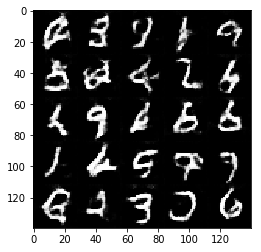

Epoch 1/2 - Batch 1400/1875:  Discriminator Loss: 0.7874... Generator Loss: 1.2968
Epoch 1/2 - Batch 1410/1875:  Discriminator Loss: 0.5876... Generator Loss: 2.4393
Epoch 1/2 - Batch 1420/1875:  Discriminator Loss: 0.5868... Generator Loss: 1.9730
Epoch 1/2 - Batch 1430/1875:  Discriminator Loss: 0.5787... Generator Loss: 1.8251
Epoch 1/2 - Batch 1440/1875:  Discriminator Loss: 0.7998... Generator Loss: 1.2199
Epoch 1/2 - Batch 1450/1875:  Discriminator Loss: 1.3346... Generator Loss: 0.7240
Epoch 1/2 - Batch 1460/1875:  Discriminator Loss: 0.6054... Generator Loss: 1.8102
Epoch 1/2 - Batch 1470/1875:  Discriminator Loss: 0.5877... Generator Loss: 1.8098
Epoch 1/2 - Batch 1480/1875:  Discriminator Loss: 0.7462... Generator Loss: 1.3428
Epoch 1/2 - Batch 1490/1875:  Discriminator Loss: 0.8137... Generator Loss: 1.2100


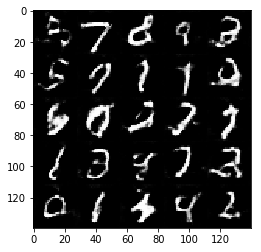

Epoch 1/2 - Batch 1500/1875:  Discriminator Loss: 0.6886... Generator Loss: 1.4837
Epoch 1/2 - Batch 1510/1875:  Discriminator Loss: 0.6314... Generator Loss: 1.7980
Epoch 1/2 - Batch 1520/1875:  Discriminator Loss: 0.6340... Generator Loss: 1.7620
Epoch 1/2 - Batch 1530/1875:  Discriminator Loss: 0.7523... Generator Loss: 1.2519
Epoch 1/2 - Batch 1540/1875:  Discriminator Loss: 0.5534... Generator Loss: 2.0503
Epoch 1/2 - Batch 1550/1875:  Discriminator Loss: 0.7850... Generator Loss: 1.2232
Epoch 1/2 - Batch 1560/1875:  Discriminator Loss: 4.4849... Generator Loss: 0.0547
Epoch 1/2 - Batch 1570/1875:  Discriminator Loss: 0.5689... Generator Loss: 1.8732
Epoch 1/2 - Batch 1580/1875:  Discriminator Loss: 0.8717... Generator Loss: 1.0958
Epoch 1/2 - Batch 1590/1875:  Discriminator Loss: 0.6201... Generator Loss: 1.8569


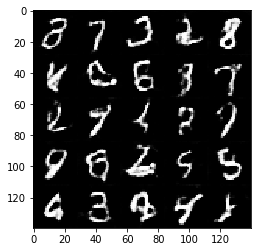

Epoch 1/2 - Batch 1600/1875:  Discriminator Loss: 0.6653... Generator Loss: 1.5412
Epoch 1/2 - Batch 1610/1875:  Discriminator Loss: 0.5546... Generator Loss: 2.0719
Epoch 1/2 - Batch 1620/1875:  Discriminator Loss: 0.7628... Generator Loss: 1.3302
Epoch 1/2 - Batch 1630/1875:  Discriminator Loss: 0.5701... Generator Loss: 2.0949
Epoch 1/2 - Batch 1640/1875:  Discriminator Loss: 0.6815... Generator Loss: 1.5096
Epoch 1/2 - Batch 1650/1875:  Discriminator Loss: 0.6727... Generator Loss: 1.8476
Epoch 1/2 - Batch 1660/1875:  Discriminator Loss: 0.5586... Generator Loss: 2.3207
Epoch 1/2 - Batch 1670/1875:  Discriminator Loss: 0.5876... Generator Loss: 2.2301
Epoch 1/2 - Batch 1680/1875:  Discriminator Loss: 0.7779... Generator Loss: 1.3014
Epoch 1/2 - Batch 1690/1875:  Discriminator Loss: 0.6500... Generator Loss: 1.7831


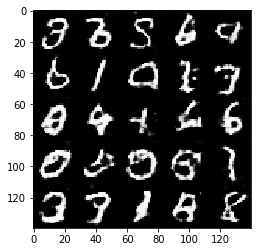

Epoch 1/2 - Batch 1700/1875:  Discriminator Loss: 1.0021... Generator Loss: 0.8944
Epoch 1/2 - Batch 1710/1875:  Discriminator Loss: 0.4726... Generator Loss: 2.5774
Epoch 1/2 - Batch 1720/1875:  Discriminator Loss: 0.6308... Generator Loss: 1.4915
Epoch 1/2 - Batch 1730/1875:  Discriminator Loss: 0.5126... Generator Loss: 2.0455
Epoch 1/2 - Batch 1740/1875:  Discriminator Loss: 0.6307... Generator Loss: 1.6171
Epoch 1/2 - Batch 1750/1875:  Discriminator Loss: 0.5190... Generator Loss: 2.0693
Epoch 1/2 - Batch 1760/1875:  Discriminator Loss: 2.0727... Generator Loss: 0.4081
Epoch 1/2 - Batch 1770/1875:  Discriminator Loss: 0.6638... Generator Loss: 1.4183
Epoch 1/2 - Batch 1780/1875:  Discriminator Loss: 0.6054... Generator Loss: 1.8054
Epoch 1/2 - Batch 1790/1875:  Discriminator Loss: 0.6280... Generator Loss: 1.6961


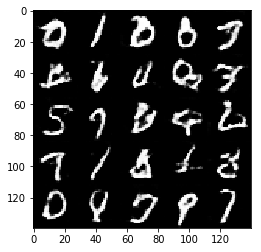

Epoch 1/2 - Batch 1800/1875:  Discriminator Loss: 0.5593... Generator Loss: 2.0116
Epoch 1/2 - Batch 1810/1875:  Discriminator Loss: 0.5667... Generator Loss: 2.2818
Epoch 1/2 - Batch 1820/1875:  Discriminator Loss: 0.6247... Generator Loss: 1.5922
Epoch 1/2 - Batch 1830/1875:  Discriminator Loss: 0.7859... Generator Loss: 1.3190
Epoch 1/2 - Batch 1840/1875:  Discriminator Loss: 0.7258... Generator Loss: 1.3613
Epoch 1/2 - Batch 1850/1875:  Discriminator Loss: 0.4736... Generator Loss: 2.5895
Epoch 1/2 - Batch 1860/1875:  Discriminator Loss: 0.7111... Generator Loss: 1.3981
Epoch 1/2 - Batch 1870/1875:  Discriminator Loss: 0.9621... Generator Loss: 0.9921
Epoch 2/2 - Batch 10/1875:  Discriminator Loss: 0.6956... Generator Loss: 1.4021
Epoch 2/2 - Batch 20/1875:  Discriminator Loss: 0.5609... Generator Loss: 2.2238
Epoch 2/2 - Batch 30/1875:  Discriminator Loss: 0.6360... Generator Loss: 1.6650
Epoch 2/2 - Batch 40/1875:  Discriminator Loss: 0.6777... Generator Loss: 1.5502
Epoch 2/2 - 

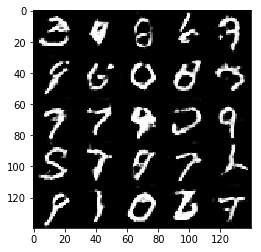

Epoch 2/2 - Batch 100/1875:  Discriminator Loss: 0.7721... Generator Loss: 1.2355
Epoch 2/2 - Batch 110/1875:  Discriminator Loss: 0.5895... Generator Loss: 2.1764
Epoch 2/2 - Batch 120/1875:  Discriminator Loss: 1.4979... Generator Loss: 0.6154
Epoch 2/2 - Batch 130/1875:  Discriminator Loss: 1.1213... Generator Loss: 0.7868
Epoch 2/2 - Batch 140/1875:  Discriminator Loss: 0.5541... Generator Loss: 2.3156
Epoch 2/2 - Batch 150/1875:  Discriminator Loss: 0.4945... Generator Loss: 2.3610
Epoch 2/2 - Batch 160/1875:  Discriminator Loss: 0.5546... Generator Loss: 2.0581
Epoch 2/2 - Batch 170/1875:  Discriminator Loss: 1.4982... Generator Loss: 0.5129
Epoch 2/2 - Batch 180/1875:  Discriminator Loss: 0.5781... Generator Loss: 1.9068
Epoch 2/2 - Batch 190/1875:  Discriminator Loss: 0.4837... Generator Loss: 2.7343


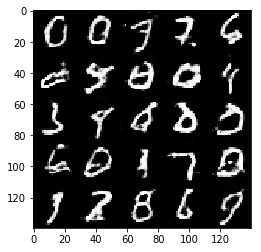

Epoch 2/2 - Batch 200/1875:  Discriminator Loss: 0.6180... Generator Loss: 2.6763
Epoch 2/2 - Batch 210/1875:  Discriminator Loss: 0.6485... Generator Loss: 1.4471
Epoch 2/2 - Batch 220/1875:  Discriminator Loss: 0.5536... Generator Loss: 1.8571
Epoch 2/2 - Batch 230/1875:  Discriminator Loss: 0.5628... Generator Loss: 1.8327
Epoch 2/2 - Batch 240/1875:  Discriminator Loss: 0.7136... Generator Loss: 1.6725
Epoch 2/2 - Batch 250/1875:  Discriminator Loss: 0.6260... Generator Loss: 1.5818
Epoch 2/2 - Batch 260/1875:  Discriminator Loss: 0.7078... Generator Loss: 1.3323
Epoch 2/2 - Batch 270/1875:  Discriminator Loss: 0.6060... Generator Loss: 1.6725
Epoch 2/2 - Batch 280/1875:  Discriminator Loss: 0.7369... Generator Loss: 1.2944
Epoch 2/2 - Batch 290/1875:  Discriminator Loss: 1.0107... Generator Loss: 0.9370


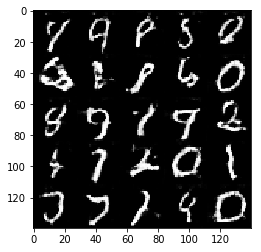

Epoch 2/2 - Batch 300/1875:  Discriminator Loss: 0.5200... Generator Loss: 2.1228
Epoch 2/2 - Batch 310/1875:  Discriminator Loss: 0.6412... Generator Loss: 1.6049
Epoch 2/2 - Batch 320/1875:  Discriminator Loss: 1.0955... Generator Loss: 0.9929
Epoch 2/2 - Batch 330/1875:  Discriminator Loss: 0.6512... Generator Loss: 1.5644
Epoch 2/2 - Batch 340/1875:  Discriminator Loss: 0.5381... Generator Loss: 2.0051
Epoch 2/2 - Batch 350/1875:  Discriminator Loss: 0.5068... Generator Loss: 2.4002
Epoch 2/2 - Batch 360/1875:  Discriminator Loss: 0.6066... Generator Loss: 1.6652
Epoch 2/2 - Batch 370/1875:  Discriminator Loss: 0.5731... Generator Loss: 1.8542
Epoch 2/2 - Batch 380/1875:  Discriminator Loss: 0.4719... Generator Loss: 2.6243
Epoch 2/2 - Batch 390/1875:  Discriminator Loss: 1.8818... Generator Loss: 0.4480


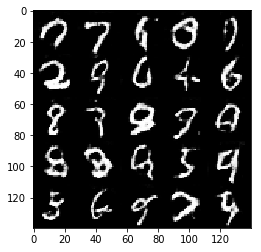

Epoch 2/2 - Batch 400/1875:  Discriminator Loss: 0.9230... Generator Loss: 0.9665
Epoch 2/2 - Batch 410/1875:  Discriminator Loss: 0.5816... Generator Loss: 1.9373
Epoch 2/2 - Batch 420/1875:  Discriminator Loss: 1.2261... Generator Loss: 0.6886
Epoch 2/2 - Batch 430/1875:  Discriminator Loss: 0.5611... Generator Loss: 2.4861
Epoch 2/2 - Batch 440/1875:  Discriminator Loss: 0.6663... Generator Loss: 1.6217
Epoch 2/2 - Batch 450/1875:  Discriminator Loss: 0.5644... Generator Loss: 1.7577
Epoch 2/2 - Batch 460/1875:  Discriminator Loss: 0.5384... Generator Loss: 2.1391
Epoch 2/2 - Batch 470/1875:  Discriminator Loss: 1.6177... Generator Loss: 0.4887
Epoch 2/2 - Batch 480/1875:  Discriminator Loss: 0.8803... Generator Loss: 1.0590
Epoch 2/2 - Batch 490/1875:  Discriminator Loss: 0.6325... Generator Loss: 1.6974


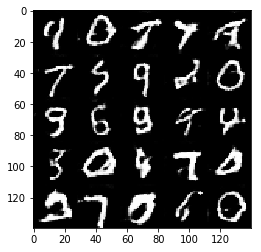

Epoch 2/2 - Batch 500/1875:  Discriminator Loss: 0.8631... Generator Loss: 1.1785
Epoch 2/2 - Batch 510/1875:  Discriminator Loss: 0.5128... Generator Loss: 2.1521
Epoch 2/2 - Batch 520/1875:  Discriminator Loss: 0.6833... Generator Loss: 1.3706
Epoch 2/2 - Batch 530/1875:  Discriminator Loss: 0.6117... Generator Loss: 1.6431
Epoch 2/2 - Batch 540/1875:  Discriminator Loss: 0.5650... Generator Loss: 1.8466
Epoch 2/2 - Batch 550/1875:  Discriminator Loss: 0.8680... Generator Loss: 1.1149
Epoch 2/2 - Batch 560/1875:  Discriminator Loss: 0.5768... Generator Loss: 2.7682
Epoch 2/2 - Batch 570/1875:  Discriminator Loss: 0.5763... Generator Loss: 2.1181
Epoch 2/2 - Batch 580/1875:  Discriminator Loss: 0.7064... Generator Loss: 2.3276
Epoch 2/2 - Batch 590/1875:  Discriminator Loss: 0.8611... Generator Loss: 1.1874


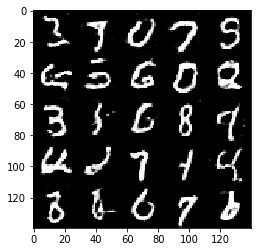

Epoch 2/2 - Batch 600/1875:  Discriminator Loss: 0.6866... Generator Loss: 2.3477
Epoch 2/2 - Batch 610/1875:  Discriminator Loss: 0.7914... Generator Loss: 2.4784
Epoch 2/2 - Batch 620/1875:  Discriminator Loss: 0.5285... Generator Loss: 2.1288
Epoch 2/2 - Batch 630/1875:  Discriminator Loss: 0.5094... Generator Loss: 2.2344
Epoch 2/2 - Batch 640/1875:  Discriminator Loss: 0.8575... Generator Loss: 1.1047
Epoch 2/2 - Batch 650/1875:  Discriminator Loss: 0.5077... Generator Loss: 2.2056
Epoch 2/2 - Batch 660/1875:  Discriminator Loss: 0.5656... Generator Loss: 2.1456
Epoch 2/2 - Batch 670/1875:  Discriminator Loss: 0.7592... Generator Loss: 1.2412
Epoch 2/2 - Batch 680/1875:  Discriminator Loss: 0.5257... Generator Loss: 2.1171
Epoch 2/2 - Batch 690/1875:  Discriminator Loss: 0.6277... Generator Loss: 1.6698


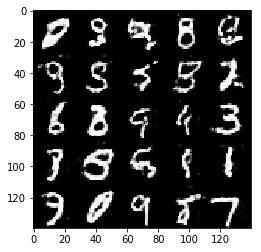

Epoch 2/2 - Batch 700/1875:  Discriminator Loss: 0.5794... Generator Loss: 1.7924
Epoch 2/2 - Batch 710/1875:  Discriminator Loss: 0.5629... Generator Loss: 2.1038
Epoch 2/2 - Batch 720/1875:  Discriminator Loss: 1.3842... Generator Loss: 0.5522
Epoch 2/2 - Batch 730/1875:  Discriminator Loss: 0.7593... Generator Loss: 1.2758
Epoch 2/2 - Batch 740/1875:  Discriminator Loss: 0.7093... Generator Loss: 1.4395
Epoch 2/2 - Batch 750/1875:  Discriminator Loss: 0.7081... Generator Loss: 1.3510
Epoch 2/2 - Batch 760/1875:  Discriminator Loss: 0.5736... Generator Loss: 1.7825
Epoch 2/2 - Batch 770/1875:  Discriminator Loss: 0.5601... Generator Loss: 1.9461
Epoch 2/2 - Batch 780/1875:  Discriminator Loss: 0.9337... Generator Loss: 0.9438
Epoch 2/2 - Batch 790/1875:  Discriminator Loss: 0.6508... Generator Loss: 2.1178


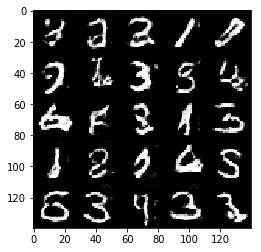

Epoch 2/2 - Batch 800/1875:  Discriminator Loss: 0.6081... Generator Loss: 1.6595
Epoch 2/2 - Batch 810/1875:  Discriminator Loss: 0.5476... Generator Loss: 2.5219
Epoch 2/2 - Batch 820/1875:  Discriminator Loss: 0.5421... Generator Loss: 1.9560
Epoch 2/2 - Batch 830/1875:  Discriminator Loss: 0.7342... Generator Loss: 1.4100
Epoch 2/2 - Batch 840/1875:  Discriminator Loss: 0.5763... Generator Loss: 1.7672
Epoch 2/2 - Batch 850/1875:  Discriminator Loss: 0.5013... Generator Loss: 2.2171
Epoch 2/2 - Batch 860/1875:  Discriminator Loss: 0.7892... Generator Loss: 1.1434
Epoch 2/2 - Batch 870/1875:  Discriminator Loss: 0.5933... Generator Loss: 1.7729
Epoch 2/2 - Batch 880/1875:  Discriminator Loss: 0.6011... Generator Loss: 2.0914
Epoch 2/2 - Batch 890/1875:  Discriminator Loss: 1.0898... Generator Loss: 2.7043


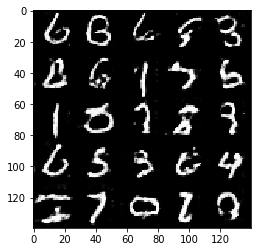

Epoch 2/2 - Batch 900/1875:  Discriminator Loss: 0.6490... Generator Loss: 1.6129
Epoch 2/2 - Batch 910/1875:  Discriminator Loss: 0.6581... Generator Loss: 1.5443
Epoch 2/2 - Batch 920/1875:  Discriminator Loss: 0.5609... Generator Loss: 1.9352
Epoch 2/2 - Batch 930/1875:  Discriminator Loss: 0.6510... Generator Loss: 1.5133
Epoch 2/2 - Batch 940/1875:  Discriminator Loss: 1.0750... Generator Loss: 0.8968
Epoch 2/2 - Batch 950/1875:  Discriminator Loss: 1.0323... Generator Loss: 0.8866
Epoch 2/2 - Batch 960/1875:  Discriminator Loss: 0.5928... Generator Loss: 1.8895
Epoch 2/2 - Batch 970/1875:  Discriminator Loss: 0.5967... Generator Loss: 2.4981
Epoch 2/2 - Batch 980/1875:  Discriminator Loss: 0.6327... Generator Loss: 1.5655
Epoch 2/2 - Batch 990/1875:  Discriminator Loss: 0.6928... Generator Loss: 1.5199


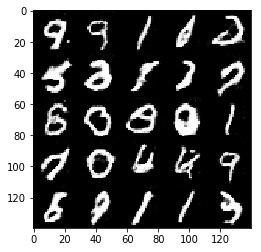

Epoch 2/2 - Batch 1000/1875:  Discriminator Loss: 0.5831... Generator Loss: 1.7153
Epoch 2/2 - Batch 1010/1875:  Discriminator Loss: 0.5227... Generator Loss: 2.1046
Epoch 2/2 - Batch 1020/1875:  Discriminator Loss: 0.5291... Generator Loss: 1.9539
Epoch 2/2 - Batch 1030/1875:  Discriminator Loss: 0.5452... Generator Loss: 1.8510
Epoch 2/2 - Batch 1040/1875:  Discriminator Loss: 0.5248... Generator Loss: 2.2548
Epoch 2/2 - Batch 1050/1875:  Discriminator Loss: 0.5653... Generator Loss: 1.7603
Epoch 2/2 - Batch 1060/1875:  Discriminator Loss: 0.7038... Generator Loss: 1.5464
Epoch 2/2 - Batch 1070/1875:  Discriminator Loss: 0.6071... Generator Loss: 1.6243
Epoch 2/2 - Batch 1080/1875:  Discriminator Loss: 0.7156... Generator Loss: 1.2996
Epoch 2/2 - Batch 1090/1875:  Discriminator Loss: 0.9702... Generator Loss: 0.9553


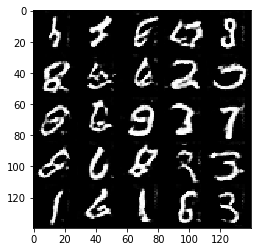

Epoch 2/2 - Batch 1100/1875:  Discriminator Loss: 0.8340... Generator Loss: 2.8129
Epoch 2/2 - Batch 1110/1875:  Discriminator Loss: 0.5792... Generator Loss: 1.8492
Epoch 2/2 - Batch 1120/1875:  Discriminator Loss: 0.6050... Generator Loss: 1.8689
Epoch 2/2 - Batch 1130/1875:  Discriminator Loss: 0.6261... Generator Loss: 1.7366
Epoch 2/2 - Batch 1140/1875:  Discriminator Loss: 0.4791... Generator Loss: 2.2901
Epoch 2/2 - Batch 1150/1875:  Discriminator Loss: 0.5813... Generator Loss: 1.8109
Epoch 2/2 - Batch 1160/1875:  Discriminator Loss: 1.3875... Generator Loss: 0.6708
Epoch 2/2 - Batch 1170/1875:  Discriminator Loss: 0.8978... Generator Loss: 1.0508
Epoch 2/2 - Batch 1180/1875:  Discriminator Loss: 0.5649... Generator Loss: 1.9311
Epoch 2/2 - Batch 1190/1875:  Discriminator Loss: 0.5420... Generator Loss: 1.9189


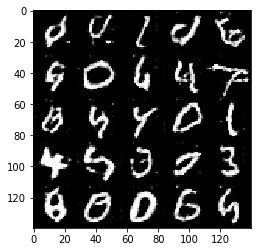

Epoch 2/2 - Batch 1200/1875:  Discriminator Loss: 0.7247... Generator Loss: 2.2933
Epoch 2/2 - Batch 1210/1875:  Discriminator Loss: 0.5659... Generator Loss: 1.8907
Epoch 2/2 - Batch 1220/1875:  Discriminator Loss: 0.5683... Generator Loss: 1.8007
Epoch 2/2 - Batch 1230/1875:  Discriminator Loss: 0.6556... Generator Loss: 1.5845
Epoch 2/2 - Batch 1240/1875:  Discriminator Loss: 0.4968... Generator Loss: 2.2302
Epoch 2/2 - Batch 1250/1875:  Discriminator Loss: 0.6388... Generator Loss: 1.6278
Epoch 2/2 - Batch 1260/1875:  Discriminator Loss: 0.5235... Generator Loss: 1.8954
Epoch 2/2 - Batch 1270/1875:  Discriminator Loss: 0.4525... Generator Loss: 2.6927
Epoch 2/2 - Batch 1280/1875:  Discriminator Loss: 0.6607... Generator Loss: 1.4738
Epoch 2/2 - Batch 1290/1875:  Discriminator Loss: 0.8710... Generator Loss: 1.1913


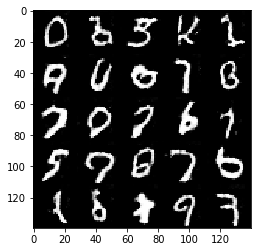

Epoch 2/2 - Batch 1300/1875:  Discriminator Loss: 0.5463... Generator Loss: 2.3802
Epoch 2/2 - Batch 1310/1875:  Discriminator Loss: 0.7699... Generator Loss: 3.3185
Epoch 2/2 - Batch 1320/1875:  Discriminator Loss: 0.7895... Generator Loss: 1.1812
Epoch 2/2 - Batch 1330/1875:  Discriminator Loss: 0.8575... Generator Loss: 1.2539
Epoch 2/2 - Batch 1340/1875:  Discriminator Loss: 0.6639... Generator Loss: 1.5054
Epoch 2/2 - Batch 1350/1875:  Discriminator Loss: 0.7967... Generator Loss: 1.1612
Epoch 2/2 - Batch 1360/1875:  Discriminator Loss: 0.6099... Generator Loss: 1.9598
Epoch 2/2 - Batch 1370/1875:  Discriminator Loss: 0.5398... Generator Loss: 1.9292
Epoch 2/2 - Batch 1380/1875:  Discriminator Loss: 0.6944... Generator Loss: 1.5854
Epoch 2/2 - Batch 1390/1875:  Discriminator Loss: 0.8927... Generator Loss: 1.1601


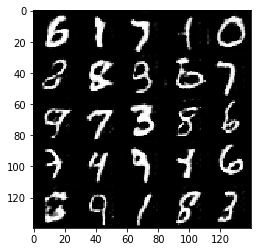

Epoch 2/2 - Batch 1400/1875:  Discriminator Loss: 0.5194... Generator Loss: 2.3251
Epoch 2/2 - Batch 1410/1875:  Discriminator Loss: 1.0391... Generator Loss: 1.0209
Epoch 2/2 - Batch 1420/1875:  Discriminator Loss: 0.5366... Generator Loss: 2.0359
Epoch 2/2 - Batch 1430/1875:  Discriminator Loss: 1.0780... Generator Loss: 0.9399
Epoch 2/2 - Batch 1440/1875:  Discriminator Loss: 0.7497... Generator Loss: 1.2267
Epoch 2/2 - Batch 1450/1875:  Discriminator Loss: 0.5707... Generator Loss: 1.7456
Epoch 2/2 - Batch 1460/1875:  Discriminator Loss: 0.5685... Generator Loss: 1.8220
Epoch 2/2 - Batch 1470/1875:  Discriminator Loss: 0.5523... Generator Loss: 2.2264
Epoch 2/2 - Batch 1480/1875:  Discriminator Loss: 1.2406... Generator Loss: 0.7419
Epoch 2/2 - Batch 1490/1875:  Discriminator Loss: 0.7956... Generator Loss: 1.1842


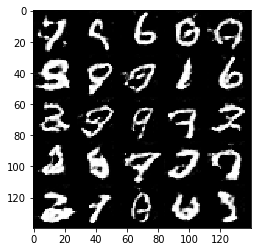

Epoch 2/2 - Batch 1500/1875:  Discriminator Loss: 0.5342... Generator Loss: 2.0104
Epoch 2/2 - Batch 1510/1875:  Discriminator Loss: 0.5285... Generator Loss: 1.9262
Epoch 2/2 - Batch 1520/1875:  Discriminator Loss: 0.4751... Generator Loss: 2.3644
Epoch 2/2 - Batch 1530/1875:  Discriminator Loss: 0.4794... Generator Loss: 2.2325
Epoch 2/2 - Batch 1540/1875:  Discriminator Loss: 0.6280... Generator Loss: 1.7719
Epoch 2/2 - Batch 1550/1875:  Discriminator Loss: 0.5892... Generator Loss: 3.2543
Epoch 2/2 - Batch 1560/1875:  Discriminator Loss: 0.5124... Generator Loss: 2.1375
Epoch 2/2 - Batch 1570/1875:  Discriminator Loss: 0.7250... Generator Loss: 1.3339
Epoch 2/2 - Batch 1580/1875:  Discriminator Loss: 0.8281... Generator Loss: 1.1725
Epoch 2/2 - Batch 1590/1875:  Discriminator Loss: 2.4782... Generator Loss: 0.2183


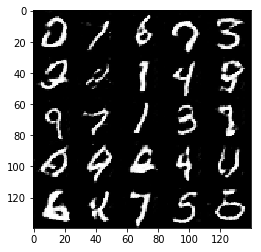

Epoch 2/2 - Batch 1600/1875:  Discriminator Loss: 0.6230... Generator Loss: 2.2155
Epoch 2/2 - Batch 1610/1875:  Discriminator Loss: 0.6508... Generator Loss: 1.6188
Epoch 2/2 - Batch 1620/1875:  Discriminator Loss: 0.4708... Generator Loss: 2.2679
Epoch 2/2 - Batch 1630/1875:  Discriminator Loss: 0.5217... Generator Loss: 2.0589
Epoch 2/2 - Batch 1640/1875:  Discriminator Loss: 0.6875... Generator Loss: 1.5184
Epoch 2/2 - Batch 1650/1875:  Discriminator Loss: 0.6822... Generator Loss: 1.3499
Epoch 2/2 - Batch 1660/1875:  Discriminator Loss: 0.5262... Generator Loss: 2.0420
Epoch 2/2 - Batch 1670/1875:  Discriminator Loss: 0.5269... Generator Loss: 2.5759
Epoch 2/2 - Batch 1680/1875:  Discriminator Loss: 0.6667... Generator Loss: 1.4389
Epoch 2/2 - Batch 1690/1875:  Discriminator Loss: 0.7182... Generator Loss: 1.3056


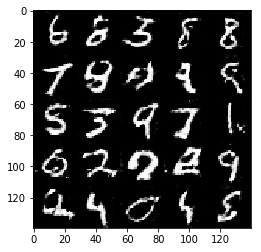

Epoch 2/2 - Batch 1700/1875:  Discriminator Loss: 1.5452... Generator Loss: 0.4780
Epoch 2/2 - Batch 1710/1875:  Discriminator Loss: 0.5370... Generator Loss: 2.6930
Epoch 2/2 - Batch 1720/1875:  Discriminator Loss: 0.6592... Generator Loss: 1.4695
Epoch 2/2 - Batch 1730/1875:  Discriminator Loss: 0.5674... Generator Loss: 1.7194
Epoch 2/2 - Batch 1740/1875:  Discriminator Loss: 0.4207... Generator Loss: 2.8963
Epoch 2/2 - Batch 1750/1875:  Discriminator Loss: 0.5805... Generator Loss: 1.8268
Epoch 2/2 - Batch 1760/1875:  Discriminator Loss: 1.3402... Generator Loss: 4.2458
Epoch 2/2 - Batch 1770/1875:  Discriminator Loss: 0.8734... Generator Loss: 4.1320
Epoch 2/2 - Batch 1780/1875:  Discriminator Loss: 0.6625... Generator Loss: 1.6977
Epoch 2/2 - Batch 1790/1875:  Discriminator Loss: 0.5022... Generator Loss: 2.1084


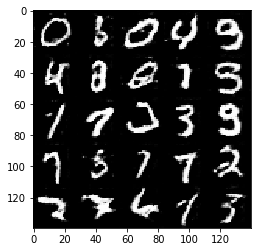

Epoch 2/2 - Batch 1800/1875:  Discriminator Loss: 0.4694... Generator Loss: 2.7817
Epoch 2/2 - Batch 1810/1875:  Discriminator Loss: 0.5013... Generator Loss: 2.4275
Epoch 2/2 - Batch 1820/1875:  Discriminator Loss: 0.4922... Generator Loss: 2.1514
Epoch 2/2 - Batch 1830/1875:  Discriminator Loss: 0.5347... Generator Loss: 1.9613
Epoch 2/2 - Batch 1840/1875:  Discriminator Loss: 0.5725... Generator Loss: 1.9842
Epoch 2/2 - Batch 1850/1875:  Discriminator Loss: 0.4891... Generator Loss: 2.2996
Epoch 2/2 - Batch 1860/1875:  Discriminator Loss: 0.4687... Generator Loss: 2.7873
Epoch 2/2 - Batch 1870/1875:  Discriminator Loss: 0.7560... Generator Loss: 1.2871


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/12662:  Discriminator Loss: 0.6394... Generator Loss: 1.5762
Epoch 1/1 - Batch 20/12662:  Discriminator Loss: 0.4948... Generator Loss: 2.1488
Epoch 1/1 - Batch 30/12662:  Discriminator Loss: 1.0160... Generator Loss: 0.8070
Epoch 1/1 - Batch 40/12662:  Discriminator Loss: 0.5341... Generator Loss: 1.8547
Epoch 1/1 - Batch 50/12662:  Discriminator Loss: 0.4764... Generator Loss: 2.1327
Epoch 1/1 - Batch 60/12662:  Discriminator Loss: 0.4147... Generator Loss: 8.4435
Epoch 1/1 - Batch 70/12662:  Discriminator Loss: 0.3874... Generator Loss: 6.6398
Epoch 1/1 - Batch 80/12662:  Discriminator Loss: 1.7299... Generator Loss: 0.3740
Epoch 1/1 - Batch 90/12662:  Discriminator Loss: 0.5626... Generator Loss: 5.0977


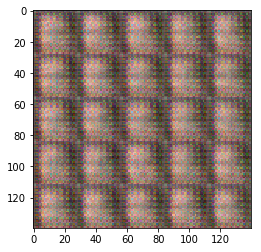

Epoch 1/1 - Batch 100/12662:  Discriminator Loss: 0.4724... Generator Loss: 2.7973
Epoch 1/1 - Batch 110/12662:  Discriminator Loss: 0.3744... Generator Loss: 4.3421
Epoch 1/1 - Batch 120/12662:  Discriminator Loss: 0.4388... Generator Loss: 4.0353
Epoch 1/1 - Batch 130/12662:  Discriminator Loss: 0.5672... Generator Loss: 2.6501
Epoch 1/1 - Batch 140/12662:  Discriminator Loss: 0.3901... Generator Loss: 5.8719
Epoch 1/1 - Batch 150/12662:  Discriminator Loss: 0.3923... Generator Loss: 3.6584
Epoch 1/1 - Batch 160/12662:  Discriminator Loss: 0.3667... Generator Loss: 3.9336
Epoch 1/1 - Batch 170/12662:  Discriminator Loss: 0.3583... Generator Loss: 4.0873
Epoch 1/1 - Batch 180/12662:  Discriminator Loss: 0.4038... Generator Loss: 3.0183
Epoch 1/1 - Batch 190/12662:  Discriminator Loss: 0.3856... Generator Loss: 3.7007


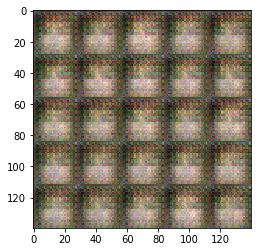

Epoch 1/1 - Batch 200/12662:  Discriminator Loss: 0.3785... Generator Loss: 3.7184
Epoch 1/1 - Batch 210/12662:  Discriminator Loss: 0.3723... Generator Loss: 6.5738
Epoch 1/1 - Batch 220/12662:  Discriminator Loss: 0.4567... Generator Loss: 2.4984
Epoch 1/1 - Batch 230/12662:  Discriminator Loss: 0.4560... Generator Loss: 2.3469
Epoch 1/1 - Batch 240/12662:  Discriminator Loss: 0.4228... Generator Loss: 2.5529
Epoch 1/1 - Batch 250/12662:  Discriminator Loss: 0.4166... Generator Loss: 2.8983
Epoch 1/1 - Batch 260/12662:  Discriminator Loss: 0.4217... Generator Loss: 2.5956
Epoch 1/1 - Batch 270/12662:  Discriminator Loss: 0.3825... Generator Loss: 4.0716
Epoch 1/1 - Batch 280/12662:  Discriminator Loss: 0.3656... Generator Loss: 4.3728
Epoch 1/1 - Batch 290/12662:  Discriminator Loss: 0.3818... Generator Loss: 3.7540


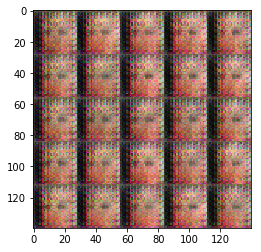

Epoch 1/1 - Batch 300/12662:  Discriminator Loss: 0.3986... Generator Loss: 2.8825
Epoch 1/1 - Batch 310/12662:  Discriminator Loss: 0.5208... Generator Loss: 1.8950
Epoch 1/1 - Batch 320/12662:  Discriminator Loss: 0.3554... Generator Loss: 4.0961
Epoch 1/1 - Batch 330/12662:  Discriminator Loss: 0.3656... Generator Loss: 3.8039
Epoch 1/1 - Batch 340/12662:  Discriminator Loss: 0.3574... Generator Loss: 5.4443
Epoch 1/1 - Batch 350/12662:  Discriminator Loss: 0.3936... Generator Loss: 3.0749
Epoch 1/1 - Batch 360/12662:  Discriminator Loss: 0.5376... Generator Loss: 2.1898
Epoch 1/1 - Batch 370/12662:  Discriminator Loss: 0.6668... Generator Loss: 5.1261
Epoch 1/1 - Batch 380/12662:  Discriminator Loss: 0.5649... Generator Loss: 2.4364
Epoch 1/1 - Batch 390/12662:  Discriminator Loss: 0.4558... Generator Loss: 2.7867


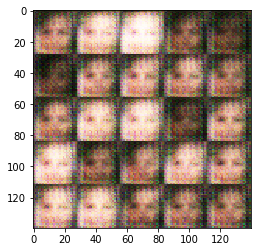

Epoch 1/1 - Batch 400/12662:  Discriminator Loss: 0.4998... Generator Loss: 2.9363
Epoch 1/1 - Batch 410/12662:  Discriminator Loss: 0.4809... Generator Loss: 2.5358
Epoch 1/1 - Batch 420/12662:  Discriminator Loss: 0.5263... Generator Loss: 2.3757
Epoch 1/1 - Batch 430/12662:  Discriminator Loss: 0.4398... Generator Loss: 5.8161
Epoch 1/1 - Batch 440/12662:  Discriminator Loss: 0.7310... Generator Loss: 1.7166
Epoch 1/1 - Batch 450/12662:  Discriminator Loss: 0.4119... Generator Loss: 3.2195
Epoch 1/1 - Batch 460/12662:  Discriminator Loss: 0.4077... Generator Loss: 3.3564
Epoch 1/1 - Batch 470/12662:  Discriminator Loss: 0.8146... Generator Loss: 1.2231
Epoch 1/1 - Batch 480/12662:  Discriminator Loss: 0.4290... Generator Loss: 2.7680
Epoch 1/1 - Batch 490/12662:  Discriminator Loss: 0.5305... Generator Loss: 2.6029


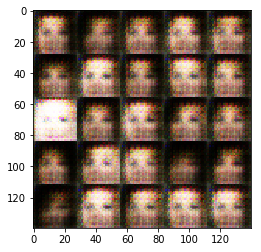

Epoch 1/1 - Batch 500/12662:  Discriminator Loss: 0.3943... Generator Loss: 3.8625
Epoch 1/1 - Batch 510/12662:  Discriminator Loss: 0.3986... Generator Loss: 4.1159
Epoch 1/1 - Batch 520/12662:  Discriminator Loss: 0.4056... Generator Loss: 3.6189
Epoch 1/1 - Batch 530/12662:  Discriminator Loss: 0.5059... Generator Loss: 2.9056
Epoch 1/1 - Batch 540/12662:  Discriminator Loss: 0.4102... Generator Loss: 3.9071
Epoch 1/1 - Batch 550/12662:  Discriminator Loss: 0.5980... Generator Loss: 1.8303
Epoch 1/1 - Batch 560/12662:  Discriminator Loss: 0.4838... Generator Loss: 2.5670
Epoch 1/1 - Batch 570/12662:  Discriminator Loss: 0.3761... Generator Loss: 3.8046
Epoch 1/1 - Batch 580/12662:  Discriminator Loss: 0.5658... Generator Loss: 1.8535
Epoch 1/1 - Batch 590/12662:  Discriminator Loss: 0.5071... Generator Loss: 4.3429


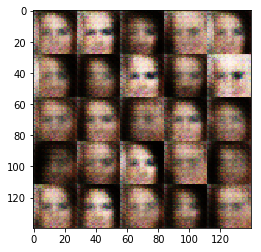

Epoch 1/1 - Batch 600/12662:  Discriminator Loss: 0.4360... Generator Loss: 3.6156
Epoch 1/1 - Batch 610/12662:  Discriminator Loss: 0.4889... Generator Loss: 2.3912
Epoch 1/1 - Batch 620/12662:  Discriminator Loss: 0.4097... Generator Loss: 3.1681
Epoch 1/1 - Batch 630/12662:  Discriminator Loss: 0.8528... Generator Loss: 1.3062
Epoch 1/1 - Batch 640/12662:  Discriminator Loss: 0.5014... Generator Loss: 2.5420
Epoch 1/1 - Batch 650/12662:  Discriminator Loss: 0.4486... Generator Loss: 3.0151
Epoch 1/1 - Batch 660/12662:  Discriminator Loss: 0.5739... Generator Loss: 3.9631
Epoch 1/1 - Batch 670/12662:  Discriminator Loss: 0.8242... Generator Loss: 1.2016
Epoch 1/1 - Batch 680/12662:  Discriminator Loss: 0.4168... Generator Loss: 3.7002
Epoch 1/1 - Batch 690/12662:  Discriminator Loss: 0.3950... Generator Loss: 4.4933


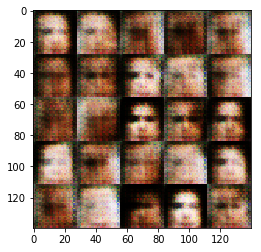

Epoch 1/1 - Batch 700/12662:  Discriminator Loss: 0.8850... Generator Loss: 5.4919
Epoch 1/1 - Batch 710/12662:  Discriminator Loss: 1.0191... Generator Loss: 0.8703
Epoch 1/1 - Batch 720/12662:  Discriminator Loss: 0.4993... Generator Loss: 2.8597
Epoch 1/1 - Batch 730/12662:  Discriminator Loss: 0.4908... Generator Loss: 3.3141
Epoch 1/1 - Batch 740/12662:  Discriminator Loss: 0.5250... Generator Loss: 4.1584
Epoch 1/1 - Batch 750/12662:  Discriminator Loss: 0.4649... Generator Loss: 2.8605
Epoch 1/1 - Batch 760/12662:  Discriminator Loss: 0.8196... Generator Loss: 1.3404
Epoch 1/1 - Batch 770/12662:  Discriminator Loss: 0.5439... Generator Loss: 3.7356
Epoch 1/1 - Batch 780/12662:  Discriminator Loss: 0.5085... Generator Loss: 2.5583
Epoch 1/1 - Batch 790/12662:  Discriminator Loss: 0.4240... Generator Loss: 2.8168


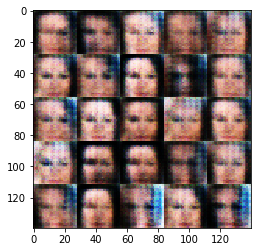

Epoch 1/1 - Batch 800/12662:  Discriminator Loss: 0.9703... Generator Loss: 4.1181
Epoch 1/1 - Batch 810/12662:  Discriminator Loss: 0.5117... Generator Loss: 2.1817
Epoch 1/1 - Batch 820/12662:  Discriminator Loss: 0.8067... Generator Loss: 1.4740
Epoch 1/1 - Batch 830/12662:  Discriminator Loss: 1.6334... Generator Loss: 0.4109
Epoch 1/1 - Batch 840/12662:  Discriminator Loss: 0.4777... Generator Loss: 5.0084
Epoch 1/1 - Batch 850/12662:  Discriminator Loss: 0.4659... Generator Loss: 3.3430
Epoch 1/1 - Batch 860/12662:  Discriminator Loss: 0.5130... Generator Loss: 2.1100
Epoch 1/1 - Batch 870/12662:  Discriminator Loss: 0.9139... Generator Loss: 0.9868
Epoch 1/1 - Batch 880/12662:  Discriminator Loss: 0.6366... Generator Loss: 4.4048
Epoch 1/1 - Batch 890/12662:  Discriminator Loss: 0.4751... Generator Loss: 2.6810


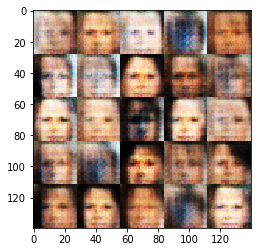

Epoch 1/1 - Batch 900/12662:  Discriminator Loss: 0.6749... Generator Loss: 1.4338
Epoch 1/1 - Batch 910/12662:  Discriminator Loss: 0.5471... Generator Loss: 2.3076
Epoch 1/1 - Batch 920/12662:  Discriminator Loss: 0.6037... Generator Loss: 1.6320
Epoch 1/1 - Batch 930/12662:  Discriminator Loss: 0.5180... Generator Loss: 3.3125
Epoch 1/1 - Batch 940/12662:  Discriminator Loss: 0.4999... Generator Loss: 2.6914
Epoch 1/1 - Batch 950/12662:  Discriminator Loss: 0.5516... Generator Loss: 2.2370
Epoch 1/1 - Batch 960/12662:  Discriminator Loss: 1.8835... Generator Loss: 0.4351
Epoch 1/1 - Batch 970/12662:  Discriminator Loss: 0.5260... Generator Loss: 2.0579
Epoch 1/1 - Batch 980/12662:  Discriminator Loss: 0.6998... Generator Loss: 1.5985
Epoch 1/1 - Batch 990/12662:  Discriminator Loss: 0.7264... Generator Loss: 2.7994


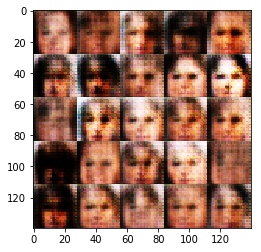

Epoch 1/1 - Batch 1000/12662:  Discriminator Loss: 0.7355... Generator Loss: 2.8324
Epoch 1/1 - Batch 1010/12662:  Discriminator Loss: 0.5526... Generator Loss: 2.0400
Epoch 1/1 - Batch 1020/12662:  Discriminator Loss: 0.9826... Generator Loss: 0.9284
Epoch 1/1 - Batch 1030/12662:  Discriminator Loss: 0.7788... Generator Loss: 1.3072
Epoch 1/1 - Batch 1040/12662:  Discriminator Loss: 1.3877... Generator Loss: 0.5275
Epoch 1/1 - Batch 1050/12662:  Discriminator Loss: 1.3215... Generator Loss: 0.8174
Epoch 1/1 - Batch 1060/12662:  Discriminator Loss: 0.4736... Generator Loss: 2.9993
Epoch 1/1 - Batch 1070/12662:  Discriminator Loss: 0.5012... Generator Loss: 2.7320
Epoch 1/1 - Batch 1080/12662:  Discriminator Loss: 0.6965... Generator Loss: 1.6554
Epoch 1/1 - Batch 1090/12662:  Discriminator Loss: 0.5615... Generator Loss: 2.1124


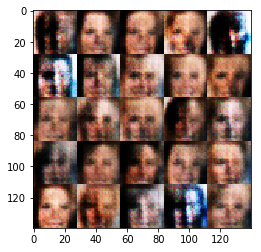

Epoch 1/1 - Batch 1100/12662:  Discriminator Loss: 0.6516... Generator Loss: 1.9070
Epoch 1/1 - Batch 1110/12662:  Discriminator Loss: 0.5767... Generator Loss: 2.8963
Epoch 1/1 - Batch 1120/12662:  Discriminator Loss: 0.8160... Generator Loss: 3.5262
Epoch 1/1 - Batch 1130/12662:  Discriminator Loss: 0.6877... Generator Loss: 1.5312
Epoch 1/1 - Batch 1140/12662:  Discriminator Loss: 0.8649... Generator Loss: 1.2659
Epoch 1/1 - Batch 1150/12662:  Discriminator Loss: 0.6693... Generator Loss: 1.7033
Epoch 1/1 - Batch 1160/12662:  Discriminator Loss: 0.6474... Generator Loss: 3.8517
Epoch 1/1 - Batch 1170/12662:  Discriminator Loss: 0.8239... Generator Loss: 1.2147
Epoch 1/1 - Batch 1180/12662:  Discriminator Loss: 0.5470... Generator Loss: 3.2269
Epoch 1/1 - Batch 1190/12662:  Discriminator Loss: 0.7510... Generator Loss: 1.4609


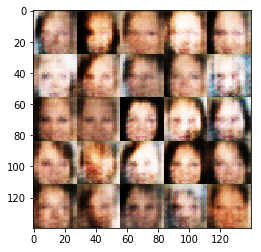

Epoch 1/1 - Batch 1200/12662:  Discriminator Loss: 0.7070... Generator Loss: 1.3193
Epoch 1/1 - Batch 1210/12662:  Discriminator Loss: 0.6648... Generator Loss: 1.9771
Epoch 1/1 - Batch 1220/12662:  Discriminator Loss: 0.8886... Generator Loss: 1.2018
Epoch 1/1 - Batch 1230/12662:  Discriminator Loss: 1.0499... Generator Loss: 5.4925
Epoch 1/1 - Batch 1240/12662:  Discriminator Loss: 0.7506... Generator Loss: 1.2936
Epoch 1/1 - Batch 1250/12662:  Discriminator Loss: 0.6483... Generator Loss: 3.5296
Epoch 1/1 - Batch 1260/12662:  Discriminator Loss: 0.4844... Generator Loss: 2.4571
Epoch 1/1 - Batch 1270/12662:  Discriminator Loss: 0.9618... Generator Loss: 1.2523
Epoch 1/1 - Batch 1280/12662:  Discriminator Loss: 0.6082... Generator Loss: 1.9542
Epoch 1/1 - Batch 1290/12662:  Discriminator Loss: 0.6734... Generator Loss: 1.7238


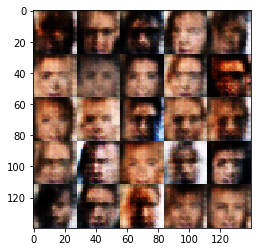

Epoch 1/1 - Batch 1300/12662:  Discriminator Loss: 0.5807... Generator Loss: 2.4107
Epoch 1/1 - Batch 1310/12662:  Discriminator Loss: 1.4932... Generator Loss: 4.5823
Epoch 1/1 - Batch 1320/12662:  Discriminator Loss: 0.5688... Generator Loss: 2.2794
Epoch 1/1 - Batch 1330/12662:  Discriminator Loss: 0.5730... Generator Loss: 2.5765
Epoch 1/1 - Batch 1340/12662:  Discriminator Loss: 0.6585... Generator Loss: 1.6141
Epoch 1/1 - Batch 1350/12662:  Discriminator Loss: 0.6303... Generator Loss: 1.9176
Epoch 1/1 - Batch 1360/12662:  Discriminator Loss: 0.6117... Generator Loss: 1.8958
Epoch 1/1 - Batch 1370/12662:  Discriminator Loss: 0.4633... Generator Loss: 2.8493
Epoch 1/1 - Batch 1380/12662:  Discriminator Loss: 0.6300... Generator Loss: 3.2203
Epoch 1/1 - Batch 1390/12662:  Discriminator Loss: 0.5607... Generator Loss: 1.9841


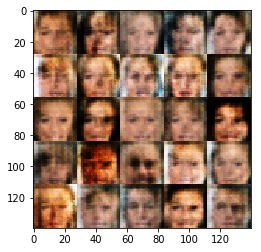

Epoch 1/1 - Batch 1400/12662:  Discriminator Loss: 0.5852... Generator Loss: 1.8185
Epoch 1/1 - Batch 1410/12662:  Discriminator Loss: 0.6944... Generator Loss: 1.5473
Epoch 1/1 - Batch 1420/12662:  Discriminator Loss: 0.6333... Generator Loss: 2.0340
Epoch 1/1 - Batch 1430/12662:  Discriminator Loss: 0.6773... Generator Loss: 1.6473
Epoch 1/1 - Batch 1440/12662:  Discriminator Loss: 1.1355... Generator Loss: 0.7808
Epoch 1/1 - Batch 1450/12662:  Discriminator Loss: 0.5221... Generator Loss: 3.0661
Epoch 1/1 - Batch 1460/12662:  Discriminator Loss: 0.5096... Generator Loss: 2.5451
Epoch 1/1 - Batch 1470/12662:  Discriminator Loss: 0.5479... Generator Loss: 2.4208
Epoch 1/1 - Batch 1480/12662:  Discriminator Loss: 0.5857... Generator Loss: 2.3739
Epoch 1/1 - Batch 1490/12662:  Discriminator Loss: 0.5197... Generator Loss: 2.2462


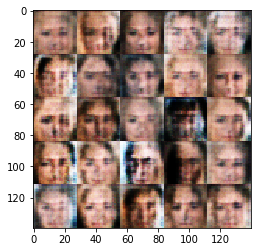

Epoch 1/1 - Batch 1500/12662:  Discriminator Loss: 0.7127... Generator Loss: 1.5015
Epoch 1/1 - Batch 1510/12662:  Discriminator Loss: 0.6283... Generator Loss: 2.3552
Epoch 1/1 - Batch 1520/12662:  Discriminator Loss: 0.6381... Generator Loss: 1.8297
Epoch 1/1 - Batch 1530/12662:  Discriminator Loss: 0.5352... Generator Loss: 2.8644
Epoch 1/1 - Batch 1540/12662:  Discriminator Loss: 0.4880... Generator Loss: 3.0133
Epoch 1/1 - Batch 1550/12662:  Discriminator Loss: 0.5888... Generator Loss: 2.1240
Epoch 1/1 - Batch 1560/12662:  Discriminator Loss: 0.4812... Generator Loss: 2.7902
Epoch 1/1 - Batch 1570/12662:  Discriminator Loss: 0.4730... Generator Loss: 2.8806
Epoch 1/1 - Batch 1580/12662:  Discriminator Loss: 1.0647... Generator Loss: 0.8684
Epoch 1/1 - Batch 1590/12662:  Discriminator Loss: 0.5962... Generator Loss: 2.2801


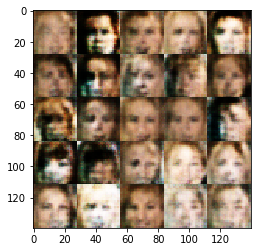

Epoch 1/1 - Batch 1600/12662:  Discriminator Loss: 0.5282... Generator Loss: 2.1039
Epoch 1/1 - Batch 1610/12662:  Discriminator Loss: 0.8949... Generator Loss: 1.0829
Epoch 1/1 - Batch 1620/12662:  Discriminator Loss: 0.9702... Generator Loss: 1.1707
Epoch 1/1 - Batch 1630/12662:  Discriminator Loss: 1.2616... Generator Loss: 0.7072
Epoch 1/1 - Batch 1640/12662:  Discriminator Loss: 0.5936... Generator Loss: 1.6330
Epoch 1/1 - Batch 1650/12662:  Discriminator Loss: 0.9307... Generator Loss: 1.0023
Epoch 1/1 - Batch 1660/12662:  Discriminator Loss: 0.7339... Generator Loss: 1.4219
Epoch 1/1 - Batch 1670/12662:  Discriminator Loss: 0.6166... Generator Loss: 1.7594
Epoch 1/1 - Batch 1680/12662:  Discriminator Loss: 0.6904... Generator Loss: 1.6019
Epoch 1/1 - Batch 1690/12662:  Discriminator Loss: 1.0728... Generator Loss: 0.8666


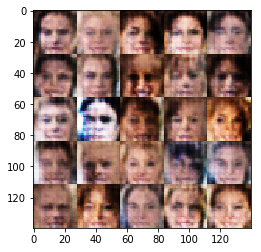

Epoch 1/1 - Batch 1700/12662:  Discriminator Loss: 1.1458... Generator Loss: 0.9041
Epoch 1/1 - Batch 1710/12662:  Discriminator Loss: 0.7110... Generator Loss: 1.7167
Epoch 1/1 - Batch 1720/12662:  Discriminator Loss: 0.6828... Generator Loss: 1.9381
Epoch 1/1 - Batch 1730/12662:  Discriminator Loss: 1.1070... Generator Loss: 0.7914
Epoch 1/1 - Batch 1740/12662:  Discriminator Loss: 0.7684... Generator Loss: 1.4630
Epoch 1/1 - Batch 1750/12662:  Discriminator Loss: 0.7940... Generator Loss: 1.2658
Epoch 1/1 - Batch 1760/12662:  Discriminator Loss: 0.5128... Generator Loss: 2.1483
Epoch 1/1 - Batch 1770/12662:  Discriminator Loss: 0.8546... Generator Loss: 1.1370
Epoch 1/1 - Batch 1780/12662:  Discriminator Loss: 0.5993... Generator Loss: 1.9709
Epoch 1/1 - Batch 1790/12662:  Discriminator Loss: 1.0705... Generator Loss: 0.7434


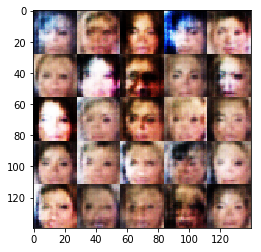

Epoch 1/1 - Batch 1800/12662:  Discriminator Loss: 0.9085... Generator Loss: 1.0113
Epoch 1/1 - Batch 1810/12662:  Discriminator Loss: 0.7086... Generator Loss: 1.3830
Epoch 1/1 - Batch 1820/12662:  Discriminator Loss: 0.6995... Generator Loss: 1.8113
Epoch 1/1 - Batch 1830/12662:  Discriminator Loss: 0.9349... Generator Loss: 1.0733
Epoch 1/1 - Batch 1840/12662:  Discriminator Loss: 0.5718... Generator Loss: 2.0322
Epoch 1/1 - Batch 1850/12662:  Discriminator Loss: 0.8800... Generator Loss: 2.7246
Epoch 1/1 - Batch 1860/12662:  Discriminator Loss: 0.6266... Generator Loss: 1.4916
Epoch 1/1 - Batch 1870/12662:  Discriminator Loss: 0.7157... Generator Loss: 1.3691
Epoch 1/1 - Batch 1880/12662:  Discriminator Loss: 0.8296... Generator Loss: 1.2018
Epoch 1/1 - Batch 1890/12662:  Discriminator Loss: 0.7431... Generator Loss: 1.4407


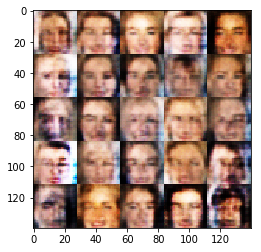

Epoch 1/1 - Batch 1900/12662:  Discriminator Loss: 0.5841... Generator Loss: 2.0270
Epoch 1/1 - Batch 1910/12662:  Discriminator Loss: 0.7007... Generator Loss: 1.4537
Epoch 1/1 - Batch 1920/12662:  Discriminator Loss: 0.6917... Generator Loss: 1.4163
Epoch 1/1 - Batch 1930/12662:  Discriminator Loss: 0.7278... Generator Loss: 1.2801
Epoch 1/1 - Batch 1940/12662:  Discriminator Loss: 0.5278... Generator Loss: 2.3884
Epoch 1/1 - Batch 1950/12662:  Discriminator Loss: 0.7310... Generator Loss: 1.4594
Epoch 1/1 - Batch 1960/12662:  Discriminator Loss: 0.6765... Generator Loss: 1.6280
Epoch 1/1 - Batch 1970/12662:  Discriminator Loss: 0.9071... Generator Loss: 0.9659
Epoch 1/1 - Batch 1980/12662:  Discriminator Loss: 0.5799... Generator Loss: 2.6416
Epoch 1/1 - Batch 1990/12662:  Discriminator Loss: 0.7706... Generator Loss: 1.8446


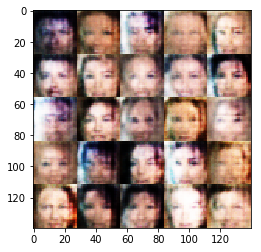

Epoch 1/1 - Batch 2000/12662:  Discriminator Loss: 0.6808... Generator Loss: 1.8490
Epoch 1/1 - Batch 2010/12662:  Discriminator Loss: 0.6451... Generator Loss: 1.6537
Epoch 1/1 - Batch 2020/12662:  Discriminator Loss: 0.6314... Generator Loss: 1.6847
Epoch 1/1 - Batch 2030/12662:  Discriminator Loss: 0.5953... Generator Loss: 1.7072
Epoch 1/1 - Batch 2040/12662:  Discriminator Loss: 0.6543... Generator Loss: 1.5566
Epoch 1/1 - Batch 2050/12662:  Discriminator Loss: 0.5899... Generator Loss: 2.1436
Epoch 1/1 - Batch 2060/12662:  Discriminator Loss: 0.5750... Generator Loss: 1.8362
Epoch 1/1 - Batch 2070/12662:  Discriminator Loss: 0.6405... Generator Loss: 2.0650
Epoch 1/1 - Batch 2080/12662:  Discriminator Loss: 0.6982... Generator Loss: 1.5433
Epoch 1/1 - Batch 2090/12662:  Discriminator Loss: 0.7776... Generator Loss: 2.7791


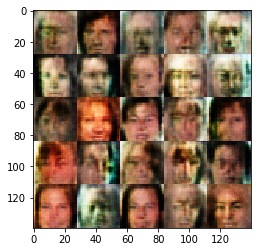

Epoch 1/1 - Batch 2100/12662:  Discriminator Loss: 0.5847... Generator Loss: 1.8568
Epoch 1/1 - Batch 2110/12662:  Discriminator Loss: 0.9136... Generator Loss: 1.2046
Epoch 1/1 - Batch 2120/12662:  Discriminator Loss: 0.4950... Generator Loss: 2.9304
Epoch 1/1 - Batch 2130/12662:  Discriminator Loss: 0.7871... Generator Loss: 2.5175
Epoch 1/1 - Batch 2140/12662:  Discriminator Loss: 0.9301... Generator Loss: 1.0652
Epoch 1/1 - Batch 2150/12662:  Discriminator Loss: 0.7797... Generator Loss: 1.2039
Epoch 1/1 - Batch 2160/12662:  Discriminator Loss: 0.6106... Generator Loss: 1.8801
Epoch 1/1 - Batch 2170/12662:  Discriminator Loss: 0.9179... Generator Loss: 1.0423
Epoch 1/1 - Batch 2180/12662:  Discriminator Loss: 0.5632... Generator Loss: 2.0141
Epoch 1/1 - Batch 2190/12662:  Discriminator Loss: 0.4999... Generator Loss: 2.4480


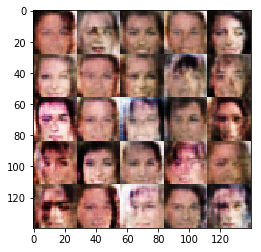

Epoch 1/1 - Batch 2200/12662:  Discriminator Loss: 0.6419... Generator Loss: 1.8055
Epoch 1/1 - Batch 2210/12662:  Discriminator Loss: 0.8401... Generator Loss: 1.0710
Epoch 1/1 - Batch 2220/12662:  Discriminator Loss: 0.7251... Generator Loss: 1.3158
Epoch 1/1 - Batch 2230/12662:  Discriminator Loss: 0.5237... Generator Loss: 2.7485
Epoch 1/1 - Batch 2240/12662:  Discriminator Loss: 0.6415... Generator Loss: 2.3595
Epoch 1/1 - Batch 2250/12662:  Discriminator Loss: 0.7362... Generator Loss: 1.3932
Epoch 1/1 - Batch 2260/12662:  Discriminator Loss: 0.8107... Generator Loss: 1.1558
Epoch 1/1 - Batch 2270/12662:  Discriminator Loss: 0.6337... Generator Loss: 1.7028
Epoch 1/1 - Batch 2280/12662:  Discriminator Loss: 0.6096... Generator Loss: 2.0698
Epoch 1/1 - Batch 2290/12662:  Discriminator Loss: 0.4754... Generator Loss: 2.4341


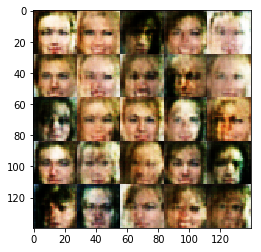

Epoch 1/1 - Batch 2300/12662:  Discriminator Loss: 0.6044... Generator Loss: 2.1201
Epoch 1/1 - Batch 2310/12662:  Discriminator Loss: 0.9165... Generator Loss: 1.1784
Epoch 1/1 - Batch 2320/12662:  Discriminator Loss: 0.9025... Generator Loss: 0.9432
Epoch 1/1 - Batch 2330/12662:  Discriminator Loss: 0.7053... Generator Loss: 1.5791
Epoch 1/1 - Batch 2340/12662:  Discriminator Loss: 0.5936... Generator Loss: 1.7560
Epoch 1/1 - Batch 2350/12662:  Discriminator Loss: 0.5722... Generator Loss: 2.1008
Epoch 1/1 - Batch 2360/12662:  Discriminator Loss: 0.6435... Generator Loss: 1.8493
Epoch 1/1 - Batch 2370/12662:  Discriminator Loss: 0.7750... Generator Loss: 1.2066
Epoch 1/1 - Batch 2380/12662:  Discriminator Loss: 0.6694... Generator Loss: 1.6526
Epoch 1/1 - Batch 2390/12662:  Discriminator Loss: 0.6754... Generator Loss: 1.4739


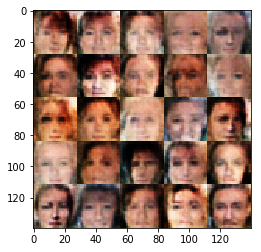

Epoch 1/1 - Batch 2400/12662:  Discriminator Loss: 0.6215... Generator Loss: 1.8838
Epoch 1/1 - Batch 2410/12662:  Discriminator Loss: 0.6054... Generator Loss: 1.7529
Epoch 1/1 - Batch 2420/12662:  Discriminator Loss: 0.6133... Generator Loss: 1.8526
Epoch 1/1 - Batch 2430/12662:  Discriminator Loss: 0.6758... Generator Loss: 1.5018
Epoch 1/1 - Batch 2440/12662:  Discriminator Loss: 0.8131... Generator Loss: 1.2294
Epoch 1/1 - Batch 2450/12662:  Discriminator Loss: 0.6062... Generator Loss: 1.8728
Epoch 1/1 - Batch 2460/12662:  Discriminator Loss: 0.6567... Generator Loss: 1.6684
Epoch 1/1 - Batch 2470/12662:  Discriminator Loss: 0.6724... Generator Loss: 2.1915
Epoch 1/1 - Batch 2480/12662:  Discriminator Loss: 0.7015... Generator Loss: 1.4104
Epoch 1/1 - Batch 2490/12662:  Discriminator Loss: 0.7376... Generator Loss: 1.4486


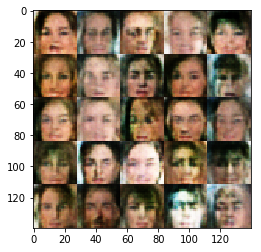

Epoch 1/1 - Batch 2500/12662:  Discriminator Loss: 0.6340... Generator Loss: 1.8030
Epoch 1/1 - Batch 2510/12662:  Discriminator Loss: 0.8528... Generator Loss: 1.0783
Epoch 1/1 - Batch 2520/12662:  Discriminator Loss: 0.8953... Generator Loss: 1.0494
Epoch 1/1 - Batch 2530/12662:  Discriminator Loss: 0.6090... Generator Loss: 2.1074
Epoch 1/1 - Batch 2540/12662:  Discriminator Loss: 0.7341... Generator Loss: 1.4794
Epoch 1/1 - Batch 2550/12662:  Discriminator Loss: 0.7588... Generator Loss: 1.2123
Epoch 1/1 - Batch 2560/12662:  Discriminator Loss: 0.6794... Generator Loss: 2.7759
Epoch 1/1 - Batch 2570/12662:  Discriminator Loss: 0.5777... Generator Loss: 1.9818
Epoch 1/1 - Batch 2580/12662:  Discriminator Loss: 1.3742... Generator Loss: 0.5167
Epoch 1/1 - Batch 2590/12662:  Discriminator Loss: 0.9268... Generator Loss: 0.9888


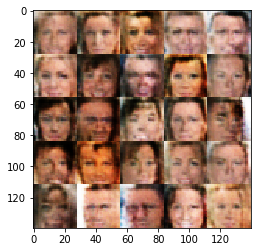

Epoch 1/1 - Batch 2600/12662:  Discriminator Loss: 0.5850... Generator Loss: 1.7895
Epoch 1/1 - Batch 2610/12662:  Discriminator Loss: 0.9025... Generator Loss: 1.0700
Epoch 1/1 - Batch 2620/12662:  Discriminator Loss: 0.6330... Generator Loss: 1.5278
Epoch 1/1 - Batch 2630/12662:  Discriminator Loss: 0.7925... Generator Loss: 1.1329
Epoch 1/1 - Batch 2640/12662:  Discriminator Loss: 0.6119... Generator Loss: 1.8856
Epoch 1/1 - Batch 2650/12662:  Discriminator Loss: 0.6813... Generator Loss: 2.0312
Epoch 1/1 - Batch 2660/12662:  Discriminator Loss: 0.6698... Generator Loss: 1.4141
Epoch 1/1 - Batch 2670/12662:  Discriminator Loss: 0.9954... Generator Loss: 1.0054
Epoch 1/1 - Batch 2680/12662:  Discriminator Loss: 0.7822... Generator Loss: 1.1937
Epoch 1/1 - Batch 2690/12662:  Discriminator Loss: 0.6658... Generator Loss: 1.4605


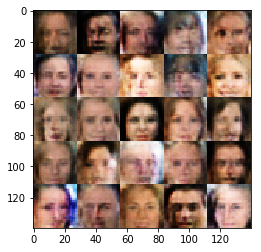

Epoch 1/1 - Batch 2700/12662:  Discriminator Loss: 0.5882... Generator Loss: 2.1205
Epoch 1/1 - Batch 2710/12662:  Discriminator Loss: 0.6584... Generator Loss: 1.7642
Epoch 1/1 - Batch 2720/12662:  Discriminator Loss: 0.8183... Generator Loss: 1.2251
Epoch 1/1 - Batch 2730/12662:  Discriminator Loss: 0.9631... Generator Loss: 1.1474
Epoch 1/1 - Batch 2740/12662:  Discriminator Loss: 0.9590... Generator Loss: 0.9341
Epoch 1/1 - Batch 2750/12662:  Discriminator Loss: 0.8273... Generator Loss: 1.5581
Epoch 1/1 - Batch 2760/12662:  Discriminator Loss: 0.7180... Generator Loss: 1.6401
Epoch 1/1 - Batch 2770/12662:  Discriminator Loss: 0.6490... Generator Loss: 2.0633
Epoch 1/1 - Batch 2780/12662:  Discriminator Loss: 0.7554... Generator Loss: 1.4741
Epoch 1/1 - Batch 2790/12662:  Discriminator Loss: 0.7154... Generator Loss: 1.9670


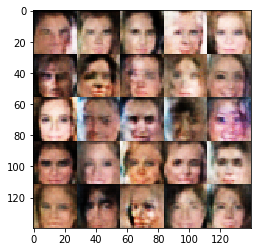

Epoch 1/1 - Batch 2800/12662:  Discriminator Loss: 0.6575... Generator Loss: 1.4748
Epoch 1/1 - Batch 2810/12662:  Discriminator Loss: 0.8536... Generator Loss: 1.1138
Epoch 1/1 - Batch 2820/12662:  Discriminator Loss: 0.6749... Generator Loss: 1.5366
Epoch 1/1 - Batch 2830/12662:  Discriminator Loss: 0.8763... Generator Loss: 1.0629
Epoch 1/1 - Batch 2840/12662:  Discriminator Loss: 0.5922... Generator Loss: 2.2251
Epoch 1/1 - Batch 2850/12662:  Discriminator Loss: 0.8775... Generator Loss: 1.2066
Epoch 1/1 - Batch 2860/12662:  Discriminator Loss: 0.6027... Generator Loss: 1.7302
Epoch 1/1 - Batch 2870/12662:  Discriminator Loss: 0.8989... Generator Loss: 1.1894
Epoch 1/1 - Batch 2880/12662:  Discriminator Loss: 0.6607... Generator Loss: 1.4603
Epoch 1/1 - Batch 2890/12662:  Discriminator Loss: 0.8093... Generator Loss: 1.1757


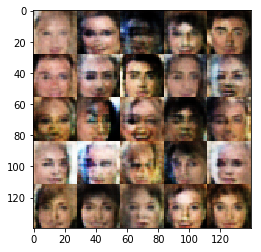

Epoch 1/1 - Batch 2900/12662:  Discriminator Loss: 0.5684... Generator Loss: 2.1778
Epoch 1/1 - Batch 2910/12662:  Discriminator Loss: 0.6715... Generator Loss: 1.4439
Epoch 1/1 - Batch 2920/12662:  Discriminator Loss: 0.6844... Generator Loss: 1.9836
Epoch 1/1 - Batch 2930/12662:  Discriminator Loss: 0.7572... Generator Loss: 1.2558
Epoch 1/1 - Batch 2940/12662:  Discriminator Loss: 1.2169... Generator Loss: 0.6822
Epoch 1/1 - Batch 2950/12662:  Discriminator Loss: 0.6065... Generator Loss: 1.8603
Epoch 1/1 - Batch 2960/12662:  Discriminator Loss: 0.7055... Generator Loss: 1.3850
Epoch 1/1 - Batch 2970/12662:  Discriminator Loss: 0.6268... Generator Loss: 1.9457
Epoch 1/1 - Batch 2980/12662:  Discriminator Loss: 0.9742... Generator Loss: 0.8683
Epoch 1/1 - Batch 2990/12662:  Discriminator Loss: 0.9111... Generator Loss: 1.1142


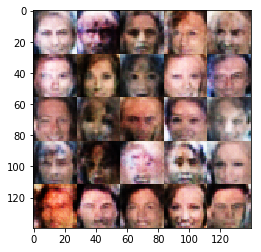

Epoch 1/1 - Batch 3000/12662:  Discriminator Loss: 0.8180... Generator Loss: 1.2653
Epoch 1/1 - Batch 3010/12662:  Discriminator Loss: 0.6742... Generator Loss: 1.7403
Epoch 1/1 - Batch 3020/12662:  Discriminator Loss: 0.8291... Generator Loss: 1.9961
Epoch 1/1 - Batch 3030/12662:  Discriminator Loss: 0.7537... Generator Loss: 1.6774
Epoch 1/1 - Batch 3040/12662:  Discriminator Loss: 0.7119... Generator Loss: 1.4329
Epoch 1/1 - Batch 3050/12662:  Discriminator Loss: 0.8090... Generator Loss: 1.4679
Epoch 1/1 - Batch 3060/12662:  Discriminator Loss: 1.0054... Generator Loss: 0.9020
Epoch 1/1 - Batch 3070/12662:  Discriminator Loss: 0.5733... Generator Loss: 1.7514
Epoch 1/1 - Batch 3080/12662:  Discriminator Loss: 0.8632... Generator Loss: 1.0427
Epoch 1/1 - Batch 3090/12662:  Discriminator Loss: 0.7370... Generator Loss: 1.4859


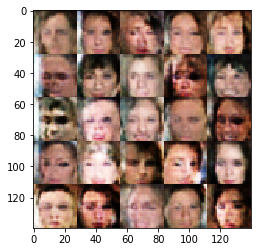

Epoch 1/1 - Batch 3100/12662:  Discriminator Loss: 0.7857... Generator Loss: 2.1831
Epoch 1/1 - Batch 3110/12662:  Discriminator Loss: 0.7847... Generator Loss: 1.2816
Epoch 1/1 - Batch 3120/12662:  Discriminator Loss: 0.7995... Generator Loss: 1.2455


KeyboardInterrupt: 

In [27]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.